In [44]:
import pandas as pd
import os

empresas = ["ABEV3", "AZUL4", "BTOW3", "B3SA3", "BBSE3", "BRML3", "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRFS3", "BPAC11", "CRFB3", "CCRO3", "CMIG4", "HGTX3", "CIEL3", "COGN3", "CPLE6", "CSAN3", "CPFE3", "CVCB3", "CYRE3", "ECOR3", "ELET6", "EMBR3", "ENBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3", "EZTC3", "FLRY3", "GGBR4", "GOAU4", "GOLL4", "NTCO3", "HAPV3", "HYPE3", "IGTA3", "GNDI3", "ITSA4", "ITUB4", "JBSS3", "JHSF3", "KLBN11", "RENT3", "LCAM3", "LAME4", "LREN3", "MGLU3", "MRFG3", "BEEF3", "MRVE3", "MULT3", "PCAR3", "PETR4", "BRDT3", "PRIO3", "QUAL3", "RADL3", "RAIL3", "SBSP3", "SANB11", "CSNA3", "SULA11", "SUZB3", "TAEE11", "VIVT3", "TIMS3", "TOTS3", "UGPA3", "USIM5", "VALE3", "VVAR3", "WEGE3", "YDUQ3"]

fundamentos = {}
arquivos = os.listdir("balancos")
for arquivo in arquivos:
    nome = arquivo[-9:-4]
    if "11" in nome:
        nome = arquivo[-10:-4]
    if nome in empresas:
        print(nome)
        balanco = pd.read_excel(f'balancos/{arquivo}', sheet_name=0)
        balanco.iloc[0, 0] = nome
        balanco.columns = balanco.iloc[0]
        balanco = balanco[1:]
        balanco = balanco.set_index(nome)
        dre = pd.read_excel(f'balancos/{arquivo}', sheet_name=1)
        dre.iloc[0, 0] = nome
        dre.columns = dre.iloc[0]
        dre = dre[1:]
        dre = dre.set_index(nome)
        fundamentos[nome] = balanco.append(dre)

ABEV3
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
AZUL4
WARNING *** file size (30309) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (30309) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
B3SA3
WARNING *** file size (64274) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (64274) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
BBAS3
WARNING *** file size (68412) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** file size (68412) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 

In [45]:
cotacoes_df = pd.read_excel("Cotacoes.xlsx")
cotacoes = {}
for empresa in cotacoes_df["Empresa"].unique():
    cotacoes[empresa] = cotacoes_df.loc[cotacoes_df['Empresa']==empresa, :]

In [46]:
for empresa in empresas:
    if cotacoes[empresa].isnull().values.any():
        cotacoes.pop(empresa)
        fundamentos.pop(empresa)
empresas = list(cotacoes.keys())

In [47]:
for empresa in fundamentos:
    tabela = fundamentos[empresa].T
    tabela.index = pd.to_datetime(tabela.index, format="%d/%m/%Y")
    tabela_cotacao = cotacoes[empresa].set_index("Date")
    tabela_cotacao = tabela_cotacao[["Adj Close"]]
    
    tabela = tabela.merge(tabela_cotacao, right_index=True, left_index=True)
    tabela.index.name = empresa
    fundamentos[empresa] = tabela

In [48]:
colunas = list(fundamentos["ABEV3"].columns)

for empresa in empresas:
    if set(colunas) != set(fundamentos[empresa].columns):
        fundamentos.pop(empresa)

In [49]:
texto_colunas = ";".join(colunas)

colunas_modificadas = []
for coluna in colunas:
    if colunas.count(coluna) == 2 and coluna not in colunas_modificadas:
        texto_colunas = texto_colunas.replace(";" + coluna + ";",";" + coluna + "_1;", 1)
        colunas_modificadas.append(coluna)
colunas = texto_colunas.split(';')

In [50]:
for empresa in fundamentos:
    fundamentos[empresa].columns = colunas

In [51]:
valores_vazios = dict.fromkeys(colunas, 0)
total_linhas = 0
for empresa in fundamentos:
    tabela = fundamentos[empresa]
    total_linhas += tabela.shape[0]
    for coluna in colunas:
        qtde_vazios = pd.isnull(tabela[coluna]).sum()
        valores_vazios[coluna] += qtde_vazios

In [52]:
remover_colunas = []
for coluna in valores_vazios:
    if valores_vazios[coluna] > 50:
        remover_colunas.append(coluna)

for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(remover_colunas, axis=1)
    fundamentos[empresa] = fundamentos[empresa].ffill()

In [53]:
fundamentos["ABEV3"].shape

(33, 72)

In [54]:
data_inicial = "12/20/2012"
data_final = "04/20/2021"

from pandas_datareader import data as web
df_ibov = web.DataReader('^BVSP', data_source='yahoo', start=data_inicial, end=data_final)

In [55]:
import numpy as np

datas = fundamentos["ABEV3"].index
for data in datas:
    if data not in df_ibov.index:
        df_ibov.loc[data] = np.nan
df_ibov = df_ibov.sort_index()
df_ibov = df_ibov.ffill()
df_ibov = df_ibov.rename(columns={"Adj Close": "IBOV"})
for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].merge(df_ibov[["IBOV"]], left_index=True, right_index=True)

In [56]:
for empresa in fundamentos:
    fundamento = fundamentos[empresa]
    fundamento = fundamento.sort_index()
    for coluna in fundamento:
        if "Adj Close" in coluna or "IBOV" in coluna:
            pass
        else:
            condicoes = [
                (fundamento[coluna].shift(1) > 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] > 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) == 0) & (fundamento[coluna] > 0),
                (fundamento[coluna].shift(1) == 0) & (fundamento[coluna] < 0),
                (fundamento[coluna].shift(1) < 0) & (fundamento[coluna] == 0),
            ]
            valores = [
                -1,
                1,
                (abs(fundamento[coluna].shift(1)) - abs(fundamento[coluna])) / abs(fundamento[coluna].shift(1)),
                1,
                -1,
                1,
            ]
            fundamento[coluna] = np.select(condicoes, valores, default=fundamento[coluna] / fundamento[coluna].shift(1) - 1)

    fundamento["Adj Close"] = fundamento["Adj Close"].shift(-1) / fundamento["Adj Close"] - 1
    fundamento["IBOV"] = fundamento["IBOV"].shift(-1) / fundamento["IBOV"] - 1
    fundamento["Resultado"] = fundamento["Adj Close"] - fundamento["IBOV"]
    condicoes = [
        (fundamento["Resultado"] > 0),
        (fundamento["Resultado"] < 0) & (fundamento["Resultado"] >= -0.02),
        (fundamento["Resultado"] < -0.02)
    ]
    valores = [2, 1, 0]
    fundamento["Decisao"] = np.select(condicoes, valores)
    
    fundamentos[empresa] = fundamento

In [57]:
colunas = list(fundamentos["ABEV3"].columns)
valores_vazios = dict.fromkeys(colunas, 0)
total_linhas = 0
for empresa in fundamentos:
    tabela = fundamentos[empresa]
    total_linhas += tabela.shape[0]
    for coluna in colunas:
        qtde_vazios = pd.isnull(tabela[coluna]).sum()
        valores_vazios[coluna] += qtde_vazios

In [58]:
remover_colunas = []
for coluna in valores_vazios:
    if valores_vazios[coluna] > (total_linhas / 3):
        remover_colunas.append(coluna)

for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(remover_colunas, axis=1)
    fundamentos[empresa] = fundamentos[empresa].fillna(0)

In [59]:
for empresa in fundamentos:
    fundamentos[empresa] = fundamentos[empresa].drop(["Adj Close", "IBOV", "Resultado"], axis=1)

In [60]:
copia_fundamentos = fundamentos.copy()

In [61]:
base_dados = pd.DataFrame()
for empresa in copia_fundamentos:
    copia_fundamentos[empresa] = copia_fundamentos[empresa][1:-1]
    copia_fundamentos[empresa] = copia_fundamentos[empresa].reset_index(drop=True)
    base_dados = base_dados.append(copia_fundamentos[empresa])

In [62]:
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
base_dados.loc[base_dados["Decisao"]==1, "Decisao"] = 0
display(base_dados['Decisao'].value_counts(normalize=True).map("{:.1%}".format))
fig = px.histogram(base_dados, x="Decisao", color="Decisao")
fig.show()

0    50.0%
2    50.0%
Name: Decisao, dtype: object

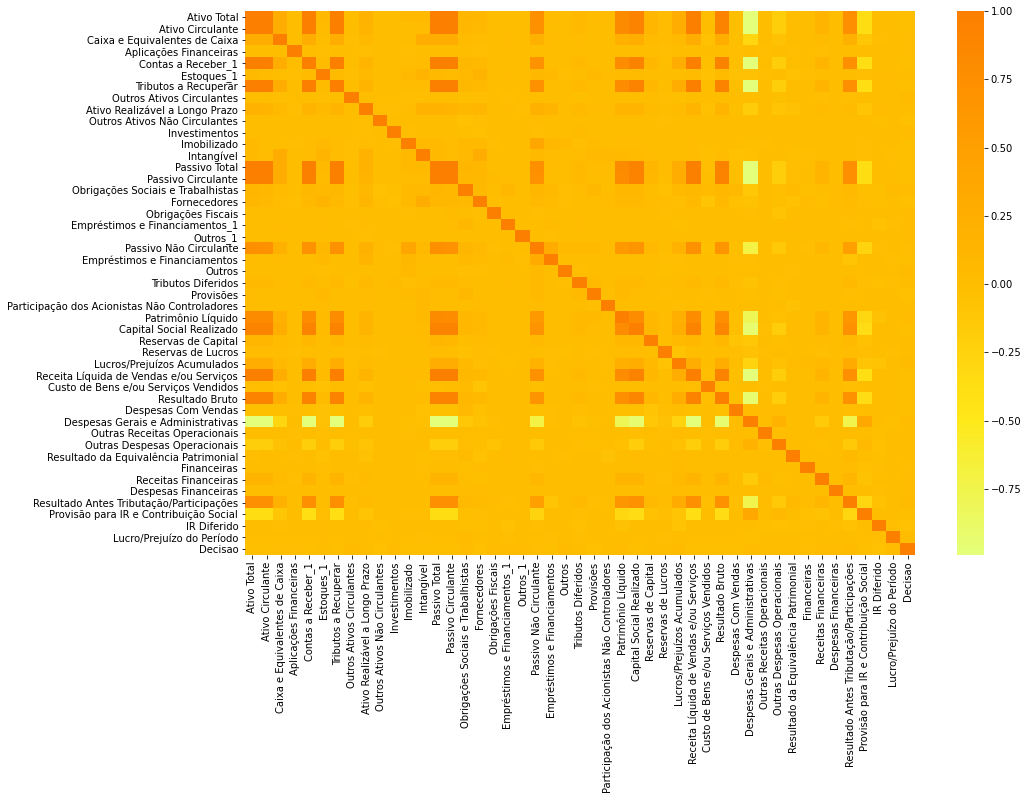

In [63]:
correlacoes = base_dados.corr()

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(correlacoes, cmap="Wistia", ax=ax)
plt.show()

In [64]:
correlacoes_encontradas = []
for coluna in correlacoes:
    for linha in correlacoes.index:
        if linha != coluna:
            valor = abs(correlacoes.loc[linha, coluna])
            if valor > 0.8 and (coluna, linha, valor) not in correlacoes_encontradas:
                correlacoes_encontradas.append((linha, coluna, valor))
                print(f"Correlação Encontrada: {linha} e {coluna}. Valor: {valor}")

Correlação Encontrada: Ativo Circulante e Ativo Total. Valor: 0.9936191613034182
Correlação Encontrada: Contas a Receber_1 e Ativo Total. Valor: 0.9897313992744241
Correlação Encontrada: Tributos a Recuperar e Ativo Total. Valor: 0.9911861955025305
Correlação Encontrada: Passivo Total e Ativo Total. Valor: 1.0
Correlação Encontrada: Passivo Circulante e Ativo Total. Valor: 0.9856898107136653
Correlação Encontrada: Patrimônio Líquido e Ativo Total. Valor: 0.8121568265673584
Correlação Encontrada: Capital Social Realizado e Ativo Total. Valor: 0.9407784719550619
Correlação Encontrada: Receita Líquida de Vendas e/ou Serviços e Ativo Total. Valor: 0.991369135249478
Correlação Encontrada: Resultado Bruto e Ativo Total. Valor: 0.9357493661129012
Correlação Encontrada: Despesas Gerais e Administrativas e Ativo Total. Valor: 0.9844249841100213
Correlação Encontrada: Contas a Receber_1 e Ativo Circulante. Valor: 0.9951703200197722
Correlação Encontrada: Tributos a Recuperar e Ativo Circulante. 

In [65]:
remover = ['Ativo Circulante', 'Contas a Receber_1', 'Tributos a Recuperar', 'Passivo Total', 'Passivo Circulante', 'Patrimônio Líquido', 'Capital Social Realizado', 'Receita Líquida de Vendas e/ou Serviços', 'Resultado Bruto', 'Despesas Gerais e Administrativas']
base_dados = base_dados.drop(remover, axis=1)

In [66]:
print(base_dados.shape)

(1882, 37)


In [67]:
from sklearn.ensemble import ExtraTreesClassifier

modelo = ExtraTreesClassifier(random_state=1)
x = base_dados.drop("Decisao", axis=1)
y = base_dados["Decisao"]
modelo.fit(x, y)

carecterisricas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
display(carecterisricas_importantes)
top10 = list(carecterisricas_importantes.index)[:10] 

,0
Fornecedores,0.032418
Outros Ativos Circulantes,0.031265
Lucros/Prejuízos Acumulados,0.031182
Resultado Antes Tributação/Participações,0.030940
Ativo Total,0.030832
Obrigações Sociais e Trabalhistas,0.030454
Obrigações Fiscais,0.030394
Custo de Bens e/ou Serviços Vendidos,0.030036
Resultado da Equivalência Patrimonial,0.029478
Tributos Diferidos,0.028723


In [68]:
from sklearn.preprocessing import StandardScaler

def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("Decisao", axis=1)

    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["Decisao"] = tabela_original["Decisao"]
    return tabela_auxiliar

nova_base_dados = ajustar_scaler(base_dados)
top10.append("Decisao")

nova_base_dados = nova_base_dados[top10].reset_index(drop=True)

In [69]:
from sklearn.model_selection import train_test_split

x = nova_base_dados.drop("Decisao", axis=1)
y = nova_base_dados["Decisao"]

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=1)

In [70]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

dummy = DummyClassifier(strategy="stratified", random_state=2)
dummy.fit(x_treino, y_treino)
previsao_dummy = dummy.predict(x_teste)

Dummy
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       231
           2       0.49      0.46      0.47       240

    accuracy                           0.48       471
   macro avg       0.48      0.48      0.48       471
weighted avg       0.48      0.48      0.48       471



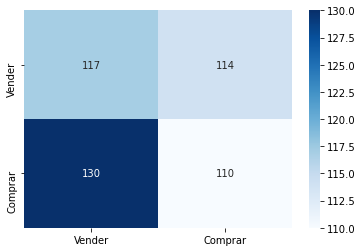

##################################################


In [71]:
def avaliar(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    report = classification_report(y_teste, previsoes)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)

avaliar(y_teste, previsao_dummy, "Dummy") 

In [72]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

modelos = {
    "AdaBoost": AdaBoostClassifier(random_state=1),
    "DecisionTree": DecisionTreeClassifier(random_state=1),
    "RandomForest": RandomForestClassifier(random_state=1),
    "ExtraTree": ExtraTreesClassifier(random_state=1),
    "GradientBoost": GradientBoostingClassifier(random_state=1),
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(random_state=1),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(random_state=1),
    "RedeNeural": MLPClassifier(random_state=1, max_iter=400),
}

AdaBoost
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       231
           2       0.55      0.54      0.55       240

    accuracy                           0.54       471
   macro avg       0.54      0.54      0.54       471
weighted avg       0.54      0.54      0.54       471



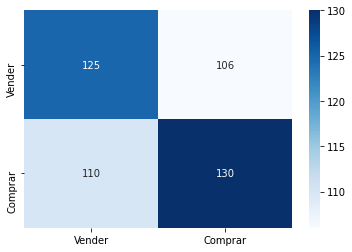

##################################################
DecisionTree
              precision    recall  f1-score   support

           0       0.50      0.53      0.52       231
           2       0.52      0.49      0.50       240

    accuracy                           0.51       471
   macro avg       0.51      0.51      0.51       471
weighted avg       0.51      0.51      0.51       471



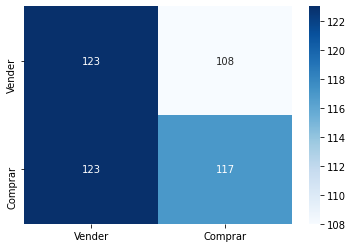

##################################################
RandomForest
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       231
           2       0.56      0.53      0.54       240

    accuracy                           0.55       471
   macro avg       0.55      0.55      0.55       471
weighted avg       0.55      0.55      0.55       471



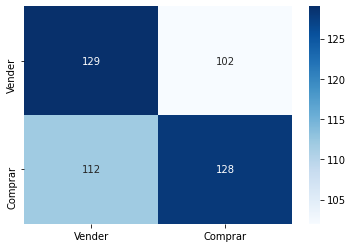

##################################################
ExtraTree
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       231
           2       0.54      0.51      0.52       240

    accuracy                           0.53       471
   macro avg       0.53      0.53      0.53       471
weighted avg       0.53      0.53      0.53       471



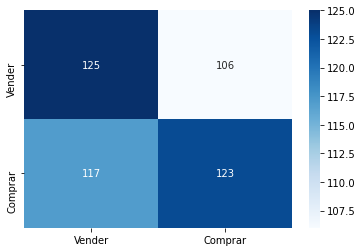

##################################################
GradientBoost
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       231
           2       0.53      0.54      0.54       240

    accuracy                           0.52       471
   macro avg       0.52      0.52      0.52       471
weighted avg       0.52      0.52      0.52       471



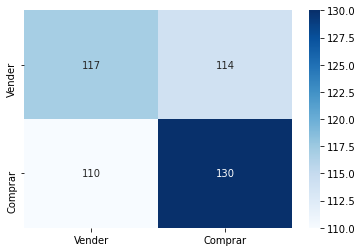

##################################################
KNN
              precision    recall  f1-score   support

           0       0.53      0.54      0.53       231
           2       0.55      0.54      0.55       240

    accuracy                           0.54       471
   macro avg       0.54      0.54      0.54       471
weighted avg       0.54      0.54      0.54       471



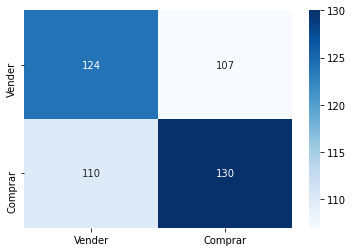

##################################################
LogisticRegression
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       231
           2       0.53      0.47      0.50       240

    accuracy                           0.52       471
   macro avg       0.52      0.52      0.52       471
weighted avg       0.52      0.52      0.52       471



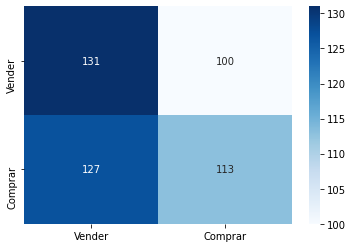

##################################################
NaiveBayes
              precision    recall  f1-score   support

           0       0.48      0.89      0.63       231
           2       0.46      0.09      0.15       240

    accuracy                           0.48       471
   macro avg       0.47      0.49      0.39       471
weighted avg       0.47      0.48      0.39       471



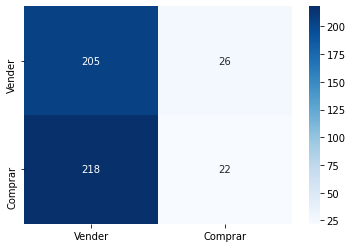

##################################################
SVM
              precision    recall  f1-score   support

           0       0.51      0.73      0.60       231
           2       0.56      0.33      0.41       240

    accuracy                           0.52       471
   macro avg       0.53      0.53      0.51       471
weighted avg       0.53      0.52      0.50       471



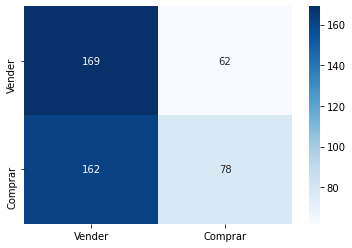

##################################################
RedeNeural
              precision    recall  f1-score   support

           0       0.52      0.64      0.57       231
           2       0.55      0.42      0.48       240

    accuracy                           0.53       471
   macro avg       0.53      0.53      0.52       471
weighted avg       0.53      0.53      0.52       471



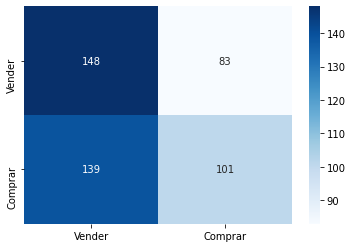

##################################################


In [73]:
for nome_modelo in modelos:
    modelo = modelos[nome_modelo]
    modelo.fit(x_treino, y_treino)
    previsoes = modelo.predict(x_teste)
    avaliar(y_teste, previsoes, nome_modelo)
    modelos[nome_modelo] = modelo 

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

modelo_final = modelos["RandomForest"]

n_estimators = range(10, 251, 30)
max_features = list(range(2, 11, 2))
max_features.append('auto')
min_samples_split = range(2, 11, 2)

precision2_score = make_scorer(precision_score, labels=[2], average='macro')

grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'n_estimators': n_estimators,
        'max_features': max_features,
        'min_samples_split': min_samples_split,
        'random_state': [1],
    },
    scoring=precision2_score,
)

resultado_grid = grid.fit(x_treino, y_treino)

RandomForest Tunado
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       231
           2       0.57      0.53      0.55       240

    accuracy                           0.56       471
   macro avg       0.56      0.56      0.56       471
weighted avg       0.56      0.56      0.56       471



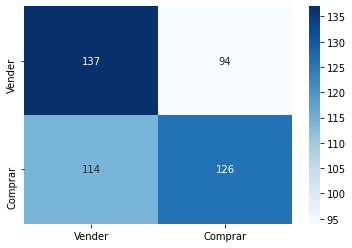

##################################################


In [75]:
modelo_tunado = resultado_grid.best_estimator_
previsoes = modelo_tunado.predict(x_teste)
avaliar(y_teste, previsoes, "RandomForest Tunado")

In [76]:
ult_tri_fundamentos = fundamentos.copy()
ult_tri_base_dados = pd.DataFrame()
lista_empresas = []
for empresa in ult_tri_fundamentos:
    ult_tri_fundamentos[empresa] = ult_tri_fundamentos[empresa][-1:]
    ult_tri_fundamentos[empresa] = ult_tri_fundamentos[empresa].reset_index(drop=True)
    ult_tri_base_dados = ult_tri_base_dados.append(ult_tri_fundamentos[empresa])
    lista_empresas.append(empresa)

In [77]:
ult_tri_base_dados = ult_tri_base_dados.reset_index(drop=True)
ult_tri_base_dados = ult_tri_base_dados[top10]
ult_tri_base_dados = ajustar_scaler(ult_tri_base_dados)
ult_tri_base_dados =ult_tri_base_dados.drop("Decisao", axis=1)

display(ult_tri_base_dados)

,Fornecedores,Outros Ativos Circulantes,Lucros/Prejuízos Acumulados,Resultado Antes Tributação/Participações,Ativo Total,Obrigações Sociais e Trabalhistas,Obrigações Fiscais,Custo de Bens e/ou Serviços Vendidos,Resultado da Equivalência Patrimonial,Tributos Diferidos
0,0.089354,1.124919,-0.789951,1.272495,-0.633966,-1.070404,-0.127804,0.212417,0.156205,0.007209
1,1.605723,-1.521465,-0.789951,-0.378475,-0.086322,0.219636,-0.126082,-4.318382,0.205891,0.236314
2,-0.460904,-0.519670,-0.789951,-0.160870,-1.407888,0.416153,-0.131067,0.158271,0.079983,0.032961
3,-0.759435,-0.027929,3.131016,0.914965,0.779875,0.219636,7.745880,0.486425,1.157823,0.104251
4,-0.215742,1.150726,0.705938,0.006051,-0.864327,-1.101884,-0.129427,0.147306,0.079983,-1.639972
...,...,...,...,...,...,...,...,...,...,...
56,-0.755353,1.880917,-0.789951,-0.895634,0.509258,1.217337,-0.129721,-0.010364,-3.618192,0.098970
57,-0.910336,-0.177522,-0.789951,-0.341734,-0.479332,-0.971126,-0.130842,0.449174,-0.000799,0.381154
58,0.062931,0.053101,-0.657707,-1.063916,1.119782,1.143185,-0.127364,-0.309313,-0.053211,0.104251
59,-0.728711,0.477621,-0.789951,-0.333399,0.299231,-1.606963,-0.129826,0.483288,-0.355309,-0.122833


In [78]:
previsoes_ult_tri = modelo_tunado.predict(ult_tri_base_dados)

carteira = []
carteira_inicial = []

for i, empresa in enumerate(lista_empresas):
    if previsoes_ult_tri[i] == 2:
        carteira_inicial.append(1000)
        cotacao = cotacoes[empresa]
        cotacao = cotacao.set_index("Date")
        cotacao_inicial = cotacao.loc["2020-12-31", "Adj Close"]
        cotacao_final = cotacao.loc["2021-03-31", "Adj Close"]
        percentual = cotacao_inicial / cotacao_final
        carteira.append(1000 * percentual)
saldo_inicial = sum(carteira_inicial)
saldo_final = sum(carteira)
print(saldo_inicial, saldo_final)
print(saldo_final / saldo_inicial)

30000 30371.665487046637
1.0123888495682212


In [81]:
variacao_ibov = df_ibov.loc["2021-03-31", "IBOV"] / df_ibov.loc["2020-12-31", "IBOV"]
print(variacao_ibov)

0.9776038086936114


In [80]:
import joblib

joblib.dump(modelo_tunado, "ia_carteira.joblib")

# para usar essa IA (pode ser em outro código)

joblib.load("")

FileNotFoundError: [Errno 2] No such file or directory: ''